In [1]:
# Minutia Cylinder-Code (MCC) Fingerprint Matching

# Import required libraries
import math
import numpy as np
# 6. Visualization Helper (Optional)
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
def _build_descriptors(minutiae,
                       R=16,                # spatial radius (pixels)
                       radial_bins=4,
                       angular_bins=8,
                       orient_bins=5):
    """
    Convert every minutia into an MCC descriptor (flattened vector).
    Returns 2-D array  shape = (N_minutiae, radial_bins*angular_bins*orient_bins)
    """
    # Pre-compute bin widths
    r_step   = R / radial_bins
    a_step   = 2*math.pi / angular_bins
    o_step   = 2*math.pi / orient_bins

    descs = []
    for i, (xi, yi, thetai) in enumerate(minutiae):
        cyl = np.zeros((radial_bins, angular_bins, orient_bins), dtype=np.float32)

        for j, (xj, yj, thetaj) in enumerate(minutiae):
            if i == j:
                continue

            # Relative position
            dx, dy = xj - xi, yj - yi
            r = math.hypot(dx, dy)
            if r > R:
                continue

            # Radial & angular bins in the minutia-centric frame
            rb = min(int(r / r_step), radial_bins - 1)  # Clamp to valid range
            ang = (math.atan2(dy, dx) - thetai) % (2*math.pi)
            ab = min(int(ang / a_step), angular_bins - 1)  # Clamp to valid range

            # Orientation difference bin (−π … π  →  0 … 2π)
            d_theta = (thetaj - thetai + math.pi) % (2*math.pi)
            ob = min(int(d_theta / o_step), orient_bins - 1)  # Clamp to valid range

            cyl[rb, ab, ob] += 1.0

        v = cyl.flatten()
        v /= np.linalg.norm(v) + 1e-6          # ℓ₂ normalisation
        descs.append(v)

    return np.vstack(descs) if descs else np.empty((0, radial_bins*angular_bins*orient_bins))

print("Fixed cylinder construction function defined.")



Fixed cylinder construction function defined.


In [3]:
# 2. Local Similarity Matrix
def _local_similarity(descA, descB):
    """
    Cosine similarity (dot product) between every pair of cylinders.
    Shape = (NA, NB), values in [0,1]
    """
    return np.clip(descA @ descB.T, 0.0, 1.0)

print("Local similarity function defined.")


Local similarity function defined.


In [13]:
# 3. Global Matching and Score
def mcc_match(minutiae_A, minutiae_B,
              R=16, radial_bins=4, angular_bins=8, orient_bins=5,
              topk=25):
    """
    Compute MCC similarity score between two fingerprints.

    Parameters:
    -----------
    minutiae_A : list of tuples
        Minutiae of first fingerprint as [(x, y, θ), ...]
    minutiae_B : list of tuples
        Minutiae of second fingerprint as [(x, y, θ), ...]
    R : int
        Spatial radius around each minutia
    radial_bins : int
        Number of radial bins in cylinder
    angular_bins : int
        Number of angular bins in cylinder
    orient_bins : int
        Number of orientation bins in cylinder
    topk : int
        Keep only top-k similarities for Hungarian assignment

    Returns:
    --------
    score : float
        Similarity score ∈ [0,1]
    """
    if not minutiae_A or not minutiae_B:
        return 0.0

    descA = _build_descriptors(minutiae_A, R, radial_bins, angular_bins, orient_bins)
    descB = _build_descriptors(minutiae_B, R, radial_bins, angular_bins, orient_bins)

    S = _local_similarity(descA, descB)

    # Keep only the strongest local similarities to speed-up the assignment
    if topk is not None and S.size > topk:
        thresh = np.partition(S.flatten(), -topk)[-topk]
        S[S < thresh] = 0.0

    # Hungarian algorithm maximises total similarity (convert to cost)
    cost = 1.0 - S
    row_idx, col_idx = linear_sum_assignment(cost)

    matched_scores = S[row_idx, col_idx]
    if matched_scores.size == 0:
        return 0.0

    # Final similarity = average of matched cylinder scores
    return float(np.mean(matched_scores))

print("MCC matching function defined.")


MCC matching function defined.


In [5]:
# 4. Test Example
# Create toy minutiae data (x, y, θ) in radians
fp1 = [(10, 10, 0.1), (40, 25, 1.2), (60, 60, 2.0), (80, 20, 0.5)]
fp2 = [(12, 11, 0.15), (42, 26, 1.25), (59, 58, 2.1)]

print("Fingerprint 1 minutiae:", fp1)
print("Fingerprint 2 minutiae:", fp2)
print("\nRunning MCC matching...")

similarity_score = mcc_match(fp1, fp2)
print(f"Similarity Score: {similarity_score:.4f}")


Fingerprint 1 minutiae: [(10, 10, 0.1), (40, 25, 1.2), (60, 60, 2.0), (80, 20, 0.5)]
Fingerprint 2 minutiae: [(12, 11, 0.15), (42, 26, 1.25), (59, 58, 2.1)]

Running MCC matching...
Similarity Score: 0.0000


In [14]:
# 5. Advanced Testing with Different Parameters
print("Testing different MCC parameters:")
print("-" * 50)

# Default parameters
score1 = mcc_match(fp1, fp2)
print(f"Default (R=16, rb=4, ab=8, ob=5): {score1:.4f}")

# Higher resolution
score2 = mcc_match(fp1, fp2, R=20, radial_bins=6, angular_bins=12, orient_bins=8)
print(f"Higher res (R=20, rb=6, ab=12, ob=8): {score2:.4f}")

# Lower resolution
score3 = mcc_match(fp1, fp2, R=12, radial_bins=3, angular_bins=6, orient_bins=4)
print(f"Lower res (R=12, rb=3, ab=6, ob=4): {score3:.4f}")


Testing different MCC parameters:
--------------------------------------------------
Default (R=16, rb=4, ab=8, ob=5): 0.0000
Higher res (R=20, rb=6, ab=12, ob=8): 0.0000
Lower res (R=12, rb=3, ab=6, ob=4): 0.0000


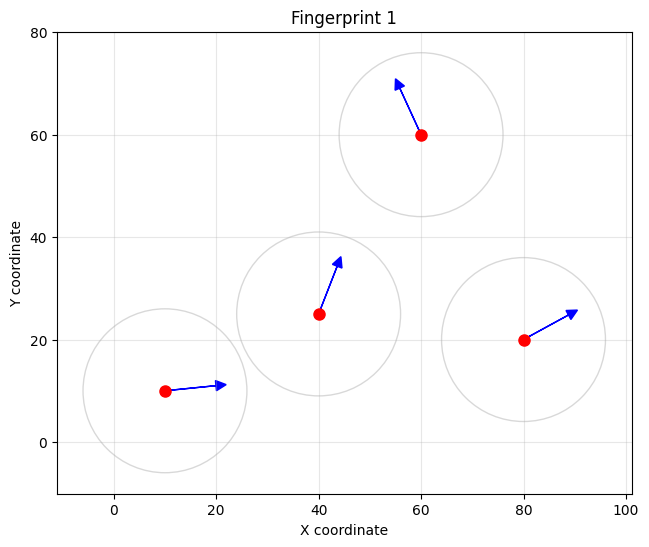

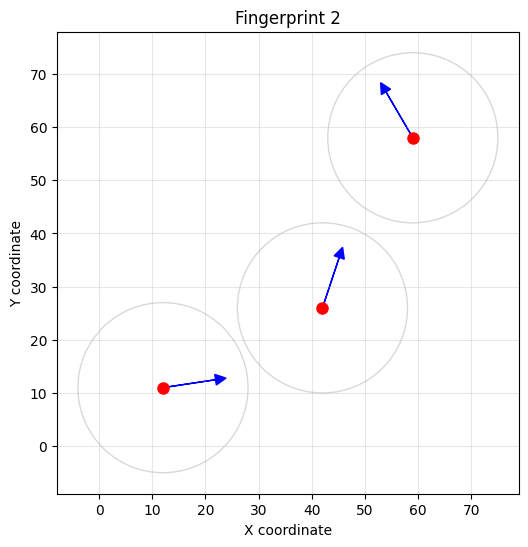

In [15]:

def visualize_minutiae(minutiae, title="Minutiae Visualization", R=16):
    """
    Visualize minutiae with their orientations and spatial radius.
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    for x, y, theta in minutiae:
        # Plot minutia point
        ax.plot(x, y, 'ro', markersize=8)
        
        # Plot orientation arrow
        dx = 10 * np.cos(theta)
        dy = 10 * np.sin(theta)
        ax.arrow(x, y, dx, dy, head_width=2, head_length=2, fc='blue', ec='blue')
        
        # Plot spatial radius circle
        circle = plt.Circle((x, y), R, fill=False, color='gray', alpha=0.3)
        ax.add_patch(circle)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    plt.show()

# Visualize our test fingerprints
visualize_minutiae(fp1, "Fingerprint 1")
visualize_minutiae(fp2, "Fingerprint 2")


Performance Analysis:
----------------------------------------
N= 5: Score=0.000, Time=0.001s
N=10: Score=0.000, Time=0.002s
N=20: Score=0.125, Time=0.001s
N=30: Score=0.172, Time=0.001s
N=40: Score=0.218, Time=0.003s
N=50: Score=0.193, Time=0.002s


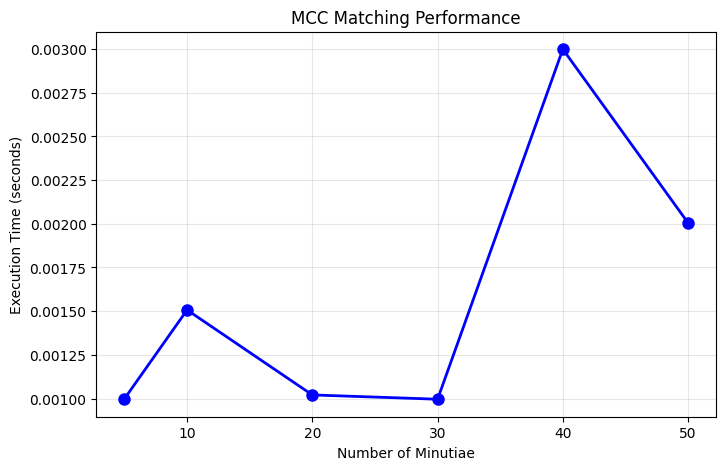

In [16]:
# 7. Performance Analysis
import time

# Generate larger test datasets
np.random.seed(42)
n_minutiae = [5, 10, 20, 30, 40, 50]
times = []

print("Performance Analysis:")
print("-" * 40)

for n in n_minutiae:
    # Generate random minutiae
    fp_large1 = [(np.random.randint(0, 100), np.random.randint(0, 100), 
                  np.random.uniform(0, 2*np.pi)) for _ in range(n)]
    fp_large2 = [(np.random.randint(0, 100), np.random.randint(0, 100), 
                  np.random.uniform(0, 2*np.pi)) for _ in range(n)]
    
    # Time the matching
    start_time = time.time()
    score = mcc_match(fp_large1, fp_large2)
    end_time = time.time()
    
    elapsed = end_time - start_time
    times.append(elapsed)
    
    print(f"N={n:2d}: Score={score:.3f}, Time={elapsed:.3f}s")

# Plot performance
plt.figure(figsize=(8, 5))
plt.plot(n_minutiae, times, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Minutiae')
plt.ylabel('Execution Time (seconds)')
plt.title('MCC Matching Performance')
plt.grid(True, alpha=0.3)
plt.show()
